# Exercise - earthquake
## Task description
In this exercise, we want to detect a jump in a GPS station coordinate time series caused by an earthquake.

GPS data is used from the Nevada Geodetic Laboratory: http://geodesy.unr.edu/NGLstation1Pages/Globalstation1List

# Let's start programming

In [28]:
# import packages
from pathlib import Path
import pandas as pd
import datetime
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from sklearn.linear_model import LinearRegression
from scipy.stats import f

In [29]:
# function to read the data
def read_txyz2(file):
    """
    This function reads .txyz2 files and returns a pd.DataFrame of the data.
    :param file: (PosixPath) path to .txyz2 file
    :return: (pd.DataFrame)
    """
    # read data (txyz2 format)
    dateparser = lambda x: datetime.datetime.strptime(x, '%y%b%d')
    df = pd.read_csv(file, delimiter=' ', skipinitialspace=True, index_col=1, parse_dates=True, date_parser=dateparser,
                     names=['station', 'decimal_year', 'x(m)', 'y(m)', 'z(m)', 'sig_x(m)', 'sig_y(m)', 'sig_z(m)',
                            'corr_xy', 'corr_yz', 'corr_xz', 'ant(m)'])
    df.name = file.stem

    return df

# Read in the data and inspect it

In [30]:
# read data
file_station1 = Path("../Data/HANM.txyz2")
file_station2 = Path("../Data/J809.txyz2")
station1 = read_txyz2(file=file_station1)
station2 = read_txyz2(file=file_station2)
# show first lines of data
station1.head()

station  decimal_year          x(m)           y(m)          z(m)  \
2014-06-04    HANM     2014.4230 -4.668744e+06  590396.986917 -4.291258e+06   
2014-06-05    HANM     2014.4257 -4.668744e+06  590396.984057 -4.291258e+06   
2014-06-06    HANM     2014.4285 -4.668744e+06  590396.979057 -4.291258e+06   
2014-06-07    HANM     2014.4312 -4.668744e+06  590396.983305 -4.291258e+06   
2014-06-08    HANM     2014.4339 -4.668744e+06  590396.981980 -4.291258e+06   

            sig_x(m)  sig_y(m)  sig_z(m)   corr_xy   corr_yz   corr_xz  ant(m)  
2014-06-04  0.002121  0.000742  0.001910 -0.358337 -0.287586  0.815400   0.002  
2014-06-05  0.002094  0.000737  0.001860 -0.351883 -0.276536  0.814428   0.002  
2014-06-06  0.002090  0.000735  0.001869 -0.346770 -0.276223  0.816916   0.002  
2014-06-07  0.002074  0.000732  0.001863 -0.337603 -0.268179  0.815269   0.002  
2014-06-08  0.002068  0.000737  0.001854 -0.361746 -0.293906  0.815487   0.002

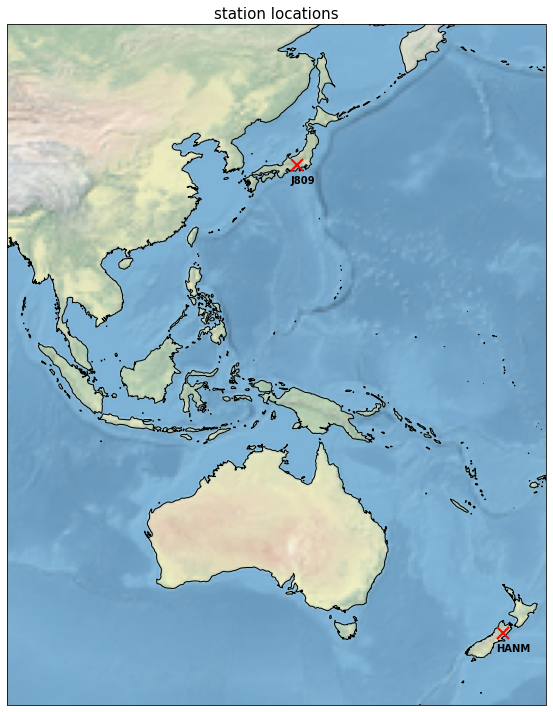

In [4]:
# plot map showing where the two stations are located
import cartopy.crs as ccrs
import cartopy.feature as cfeature

lonlat_1 = (172.793, -42.553)
lonlat_2 = (138.457, 35.674)

plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_extent([90, 180, -45, 50])

plt.plot(lonlat_1[0], lonlat_1[1], color='r', linewidth=2, marker='x', markersize=12, markeredgewidth=2, transform=ccrs.Geodetic())
plt.plot(lonlat_2[0], lonlat_2[1], color='r', linewidth=2, marker='x', markersize=12, markeredgewidth=2, transform=ccrs.Geodetic())
plt.text(lonlat_1[0] + 4.5, lonlat_1[1] - 3, station1.name, horizontalalignment='right', weight='bold', transform=ccrs.Geodetic())
plt.text(lonlat_2[0] + 3, lonlat_2[1] - 3, station2.name, horizontalalignment='right', weight='bold', transform=ccrs.Geodetic())
ax.coastlines(resolution='50m')
plt.title('station locations', fontsize=15)
plt.tight_layout()

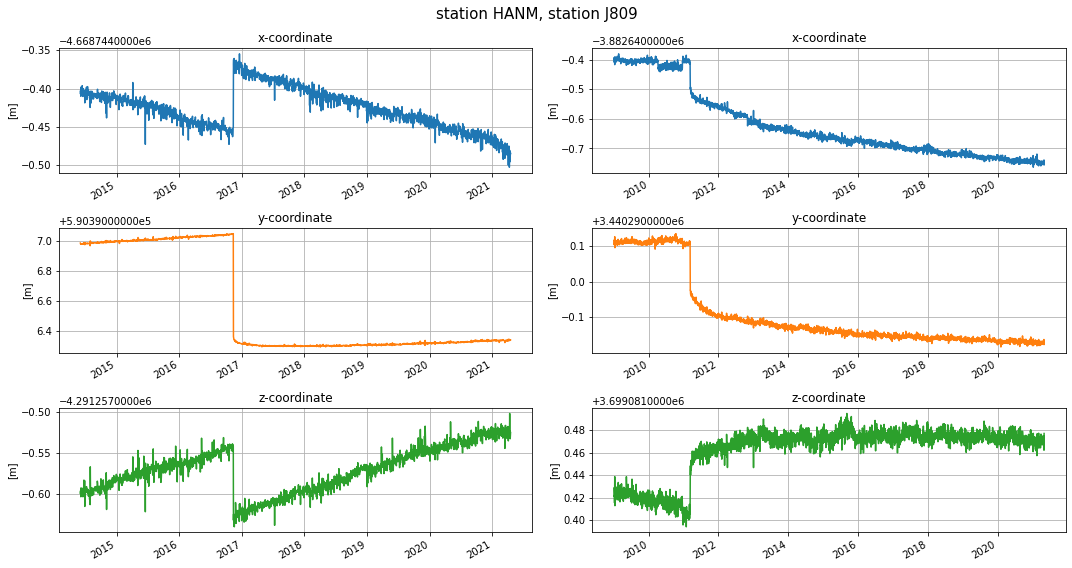

In [31]:
# plot time series to inspect the data
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,8))
station1['x(m)'].plot(ax=axes[0,0], color='C0', title='x-coordinate', xlabel='', ylabel='[m]', grid=True)
station1['y(m)'].plot(ax=axes[1,0], color='C1', title='y-coordinate', xlabel='', ylabel='[m]', grid=True)
station1['z(m)'].plot(ax=axes[2,0], color='C2', title='z-coordinate', xlabel='', ylabel='[m]', grid=True)
station2['x(m)'].plot(ax=axes[0,1], color='C0', title='x-coordinate', xlabel='', ylabel='[m]', grid=True)
station2['y(m)'].plot(ax=axes[1,1], color='C1', title='y-coordinate', xlabel='', ylabel='[m]', grid=True)
station2['z(m)'].plot(ax=axes[2,1], color='C2', title='z-coordinate', xlabel='', ylabel='[m]', grid=True)
plt.suptitle('station {}, station {}'.format(station1.name, station2.name), fontsize=15)
plt.tight_layout()

# Transformation: $(x,y,z) \rightarrow (east,north,up)$

1. Transform: $(x,y,z) \rightarrow (\phi,\lambda,h$)
2. Transform: $(\phi,\lambda,h) \rightarrow (east,north,up)$

**Formulas:**

$\lambda=arctan(\frac{y}{x})$

$\phi=arcsin(\frac{z}{\sqrt{x²+y²+z²}})$

$h=\sqrt{x²+y²+z²}-R_{Earth}$

\begin{equation}
\begin{bmatrix}
e \\
n \\
u \\
\end{bmatrix}
=
\begin{bmatrix}
-sin\lambda & cos\lambda & 0\\
-sin\phi cos\lambda & -sin\phi sin\lambda & cos\phi \\
cos\phi cos\lambda & cos \phi sin\lambda & sin \phi
\end{bmatrix}
\begin{bmatrix}
x-x_{ref} \\
y-y_{ref} \\
z-z_{ref} \\
\end{bmatrix}
\end{equation}

In [32]:
# FOR STATION 1
# xyz to phi, lambda, height
col_xyz = ['x(m)', 'y(m)', 'z(m)']
# we define a reference and calculate phi, lambda, height for that reference
ref = station1[col_xyz].iloc[0]  
l_ref = np.arctan2(ref['y(m)'], ref['x(m)'])
phi_ref = np.arcsin(ref['z(m)'] / np.sqrt((ref[col_xyz]**2).sum()))

In [33]:
# rotation matrix
R = np.full(shape=(3, 3), fill_value=np.nan)
R[0, :] = np.array((-np.sin(l_ref), np.cos(l_ref), 0))
R[1, :] = np.array((-np.sin(phi_ref)*np.cos(l_ref), -np.sin(phi_ref)*np.sin(l_ref), np.cos(phi_ref)))
R[2, :] = np.array((np.cos(phi_ref)*np.cos(l_ref), np.cos(phi_ref)*np.sin(l_ref), np.sin(phi_ref)))

S = station1[col_xyz]-ref[col_xyz]

# matrix multiplication
enu = R@S.T
station1 = enu.T
station1.columns = ['east(m)', 'north(m)', 'up(m)']

In [34]:
# FOR STATION 2
# we define a reference and calculate phi, lambda, height for that reference
ref = station2[col_xyz].iloc[0]
l_ref = np.arctan2(ref['y(m)'], ref['x(m)'])
phi_ref = np.arcsin(ref['z(m)'] / np.sqrt((ref[col_xyz]**2).sum()))

In [35]:
# rotation matrix
R = np.full(shape=(3, 3), fill_value=np.nan)
R[0, :] = np.array((-np.sin(l_ref), np.cos(l_ref), 0))
R[1, :] = np.array((-np.sin(phi_ref)*np.cos(l_ref), -np.sin(phi_ref)*np.sin(l_ref), np.cos(phi_ref)))
R[2, :] = np.array((np.cos(phi_ref)*np.cos(l_ref), np.cos(phi_ref)*np.sin(l_ref), np.sin(phi_ref)))

S = station2[col_xyz]-ref[col_xyz]

# matrix multiplication
enu = R@S.T
station2 = enu.T
station2.columns = ['east(m)', 'north(m)', 'up(m)']

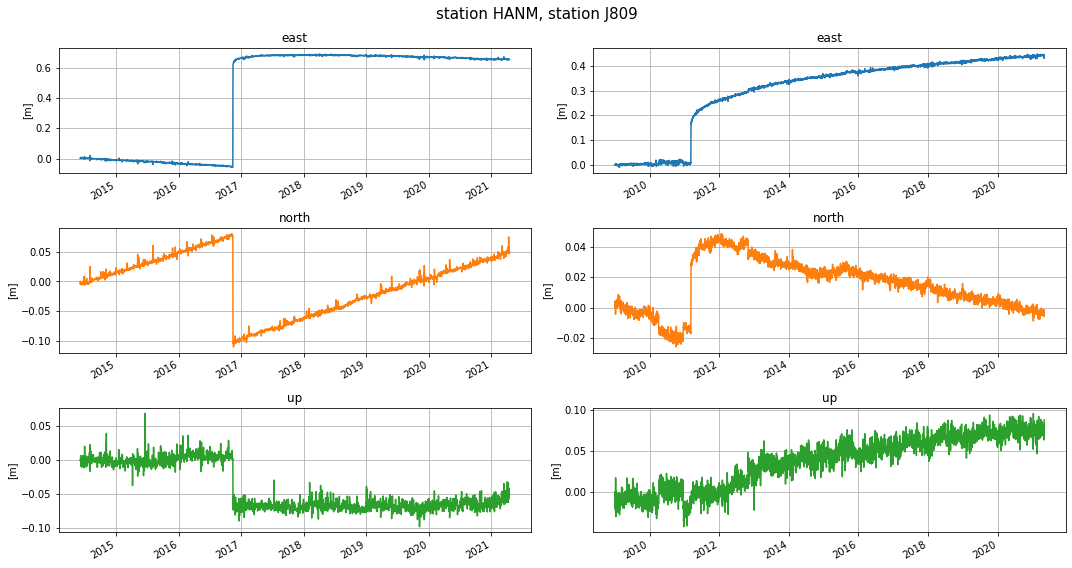

In [36]:
# plot time series to inspect the data
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,8))
station1['east(m)'].plot(ax=axes[0,0], color='C0', title='east', xlabel='', ylabel='[m]', grid=True)
station1['north(m)'].plot(ax=axes[1,0], color='C1', title='north', xlabel='', ylabel='[m]', grid=True)
station1['up(m)'].plot(ax=axes[2,0], color='C2', title='up', xlabel='', ylabel='[m]', grid=True)
station2['east(m)'].plot(ax=axes[0,1], color='C0', title='east', xlabel='', ylabel='[m]', grid=True)
station2['north(m)'].plot(ax=axes[1,1], color='C1', title='north', xlabel='', ylabel='[m]', grid=True)
station2['up(m)'].plot(ax=axes[2,1], color='C2', title='up', xlabel='', ylabel='[m]', grid=True)
plt.suptitle('station HANM, station J809', fontsize=15)
plt.tight_layout()

# What do you see?
- How do the time series look like?
- What can you say about them by visually inspecting them?
- How long are the time series?
- Are there any outliers or breaks in the time series? How do we deal with that?
- ...

# Outlier elimination

Idea: 
- First, we calculate a floating median of the time series. This is done because the median is robust against outliers. 
- Based on the difference between the floating median and the observations we can decide if they are outliers or not.
- Therefore, we need to know the noise floor of the time series. This can be calculated based on the median of a floating standard deviation.

Alternatively, you could do an iterative least squares adjustment including outlier detection.

In [37]:
# generate equidistant time series (missing values)
idx1 = pd.date_range(station1.index[0], station1.index[-1])
idx2 = pd.date_range(station2.index[0], station2.index[-1])

col_enu = ['east(m)', 'north(m)', 'up(m)']
station1 = station1[col_enu].reindex(idx1)
station2 = station2[col_enu].reindex(idx2)

station1.head()

east(m)  north(m)     up(m)
2014-06-04  0.000000  0.000000  0.000000
2014-06-05  0.002387 -0.004956 -0.000782
2014-06-06  0.007626 -0.001847 -0.001486
2014-06-07  0.004052 -0.002583  0.006765
2014-06-08  0.003858 -0.002791 -0.009420

In [38]:
# calculate floating median
col_median = ['median_e', 'median_n', 'median_u']
station1[col_median] = station1[col_enu].rolling(window=30, center=True, min_periods=15).median()
station2[col_median] = station2[col_enu].rolling(window=30, center=True, min_periods=15).median()

# interpolate floating median
station1[col_median] = station1[col_median].interpolate(limit_direction='both')
station2[col_median] = station2[col_median].interpolate(limit_direction='both')

station1.head()

east(m)  north(m)     up(m)  median_e  median_n  median_u
2014-06-04  0.000000  0.000000  0.000000  0.004353 -0.003440 -0.001397
2014-06-05  0.002387 -0.004956 -0.000782  0.004369 -0.003192 -0.001090
2014-06-06  0.007626 -0.001847 -0.001486  0.004385 -0.002944 -0.000782
2014-06-07  0.004052 -0.002583  0.006765  0.004369 -0.002873 -0.001090
2014-06-08  0.003858 -0.002791 -0.009420  0.004385 -0.002802 -0.001397

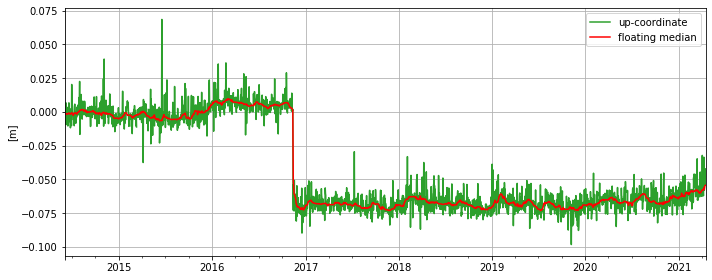

In [39]:
# plot
plt.figure()
station1['up(m)'].plot(figsize=(10, 4), label='up-coordinate', ylabel='[m]', color='tab:green')
station1['median_u'].plot(label='floating median', grid=True, color='r')
plt.legend()
plt.tight_layout()

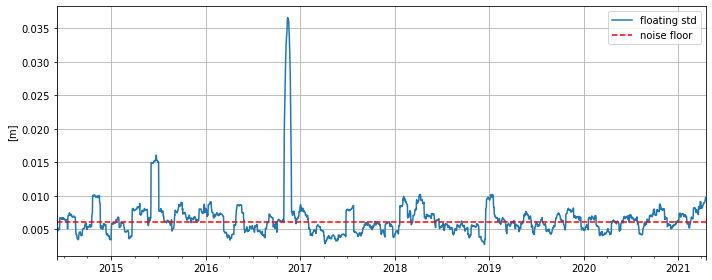

In [40]:
# calculate floating std, then take median to get noise floor
col_std = ['std_e', 'std_n', 'std_u']
station1[col_std] = station1[col_enu].rolling(window=30, center=True, min_periods=15).std()
station2[col_std] = station2[col_enu].rolling(window=30, center=True, min_periods=15).std()
# noise floor
noise_floor_1 = station1[col_std].median()
noise_floor_2 = station2[col_std].median()

# plot
plt.figure()
station1['std_u'].plot(figsize=(10, 4), label='floating std', grid=True, ylabel=['m'])
plt.axhline(noise_floor_1['std_u'], color='r', linestyle='--', label='noise floor')
plt.legend()
plt.tight_layout()

In [41]:
# subtract floating median of coordinates
station1[['e_diff', 'n_diff', 'u_diff']] = (station1[col_enu].values - station1[col_median].values)
station2[['e_diff', 'n_diff', 'u_diff']] = (station2[col_enu].values - station2[col_median].values)

# if the absolute difference is bigger than 3-times the noise floor, we assume an outlier occurs
station1['outliers_e'] = station1['e_diff'].abs() > 3 * noise_floor_1['std_e']
station1['outliers_n'] = station1['n_diff'].abs() > 3 * noise_floor_1['std_n']
station1['outliers_u'] = station1['u_diff'].abs() > 3 * noise_floor_1['std_u']
station2['outliers_e'] = station2['e_diff'].abs() > 3 * noise_floor_2['std_e']
station2['outliers_n'] = station2['n_diff'].abs() > 3 * noise_floor_2['std_n']
station2['outliers_u'] = station2['u_diff'].abs() > 3 * noise_floor_2['std_u']

# if in one coordinate an outlier occurs, we flag all three coordinates as outlier
station1['outliers'] = station1[['outliers_e', 'outliers_n', 'outliers_u']].any(axis=1)
station2['outliers'] = station2[['outliers_e', 'outliers_n', 'outliers_u']].any(axis=1)
station1.head()

east(m)  north(m)     up(m)  median_e  median_n  median_u  \
2014-06-04  0.000000  0.000000  0.000000  0.004353 -0.003440 -0.001397   
2014-06-05  0.002387 -0.004956 -0.000782  0.004369 -0.003192 -0.001090   
2014-06-06  0.007626 -0.001847 -0.001486  0.004385 -0.002944 -0.000782   
2014-06-07  0.004052 -0.002583  0.006765  0.004369 -0.002873 -0.001090   
2014-06-08  0.003858 -0.002791 -0.009420  0.004385 -0.002802 -0.001397   

               std_e     std_n     std_u    e_diff    n_diff    u_diff  \
2014-06-04  0.001973  0.001691  0.004764 -0.004353  0.003440  0.001397   
2014-06-05  0.001976  0.001648  0.005102 -0.001983 -0.001764  0.000308   
2014-06-06  0.001919  0.001606  0.005079  0.003240  0.001097 -0.000704   
2014-06-07  0.002115  0.001563  0.005033 -0.000317  0.000290  0.007854   
2014-06-08  0.002058  0.001537  0.005062 -0.000528  0.000011 -0.008022   

            outliers_e  outliers_n  outliers_u  outliers  
2014-06-04       False       False       False     False  
2014-06-05       False       False       False     False  
2014-06-06       False       False       False     False  
2014-06-07       False       False       False     False  
2014-06-08       False       False       False     False

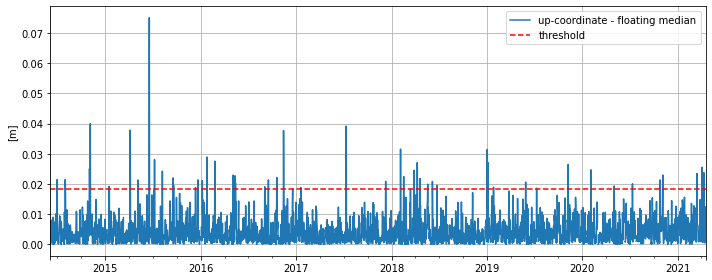

In [42]:
# plot
plt.figure()
station1['u_diff'].abs().plot(figsize=(10, 4), label='up-coordinate - floating median', ylabel='[m]', grid=True)
plt.axhline(3*noise_floor_1['std_u'], color='r', linestyle='--', label='threshold')
plt.legend()
plt.tight_layout()

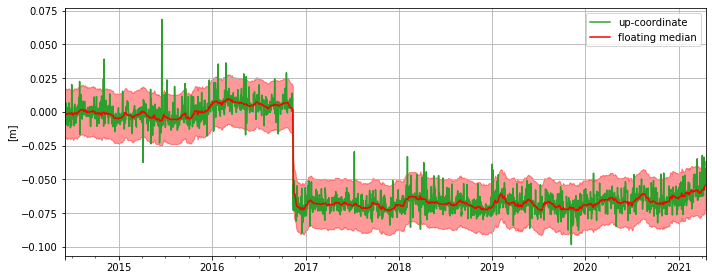

In [43]:
# plot
plt.figure()
station1['up(m)'].plot(figsize=(10, 4), label='up-coordinate', ylabel='[m]', color='tab:green')
station1['median_u'].plot(label='floating median', grid=True, color='r')
plt.fill_between(station1['median_u'].index, station1['median_u']+3*noise_floor_1['std_u'], station1['median_u']-3*noise_floor_1['std_u'], color='r', alpha=0.4)
plt.legend()
plt.tight_layout()

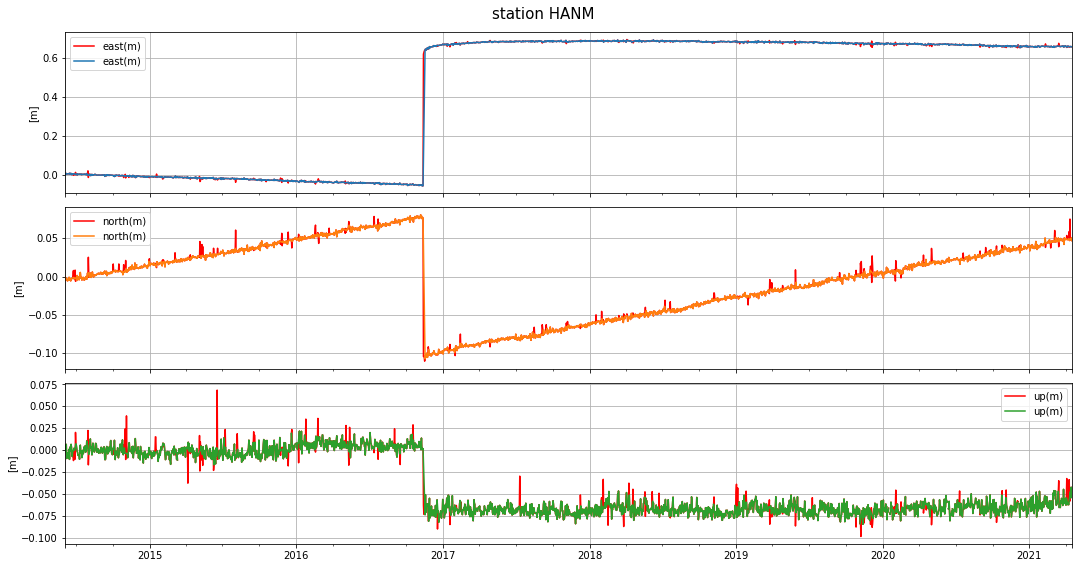

In [44]:
# plot
(ax1, ax2, ax3) = station1[col_enu].plot(subplots=True, figsize=(15, 8), color='r', ylabel=['m'])
# delete outliers
station1 = station1[~station1['outliers']]
station1[col_enu].plot(subplots=True, ax=(ax1, ax2, ax3), color=['C0', 'C1', 'C2'], linewidth=1.5, grid=True)
plt.suptitle('station HANM', fontsize=15)
plt.tight_layout()

(ax1, ax2, ax3) = station2[col_enu].plot(subplots=True, figsize=(15, 8), color='r', ylabel=['m'])
# delete outliers
station2 = station2[~station2['outliers']]
station2[col_enu].plot(subplots=True, ax=(ax1, ax2, ax3), color=['C0', 'C1', 'C2'], linewidth=1.5, grid=True)
plt.suptitle('station J809', fontsize=15)
plt.tight_layout()

# Now we can start with the actual task ...
**$\rightarrow$ Detect jumps in the time series caused by earthquakes**

Therefore, we are applying a moving **Chow test**.

A **Chow test** is a test of whether the coefficients in two different linear regressions on different data sets are equal.

Regression model for entire dataset: 
$y = a+bx+\epsilon$

Regression model for data set one: 
$y_1 = a_1+b_1x_1+\epsilon_1$

Regression model for data set two:
$y_2 = a_2+b_2x_2+\epsilon_2$

The null hypothesis of the Chow test asserts that $a_1=a_2$, and $b_1=b_2$

Chow test statistic = 
$\frac{(S_C-(S_1+S_2)) / k}{(S_1+S_2) / (N_1+N_2-2k)}$

where $S_C$ is the sum of squared residuals from the entire data, $S_1$ is the sum of squared residuals from the first group, and $S_2$ is the sum of squared residuals from the second group. $N_1$ and $N_2$ are the number of observations in each group and $k$ is the total number of parameters.
The test statistic follows the F-distribution with $k$ and $N_1$+$N_2-2k$ degrees of freedom.

In [45]:
# function to do a linear regression
def lin_reg(ds):
    """
    This function does a linear regression for the given data (ds).
    :param ds: (pd.Series) data
    :return: regression line at every index in ds
    """
    idx = ds.index
    X = (idx - idx[0]).total_seconds().values.reshape(-1, 1)

    reg = LinearRegression()
    model = reg.fit(X, ds)
    
    return model.predict(X)

In [46]:
# function to do a chow test
def chow_test(df, b, dt=30, alpha=0.05, plot=False):
    """
    This function does a Chow test for the data given (df).
    It calculates linear regressions for the data left and right (+-dt) of the break and for the full data.
    If the sum of the squared residuals of the left+right linear regressions are significantly smaller
    than the residuals of the full linear regression, it is assumed that a break occurs.
    :param df: (pd.DataFrame) data
    :param b: (pd.Timestamp) assumed break
    :param dt: (int) days considered left and right of b, default=30
    :param alpha: (np.float) significance level, default=0.05
    :param plot: (bool) should a plot be done?, default=False
    :return: flag, p_value, stat, c_value, score
    """
    # sample data (left and right of break and full data)
    left = df.loc[b-pd.Timedelta(f"{dt}D"):b]
    right = df.loc[b:b+pd.Timedelta(f"{dt}D")]
    full = df.loc[b-pd.Timedelta(f"{dt}D"):b+pd.Timedelta(f"{dt}D")]
    
    # linear regression for sample data (left and right of break and full data)
    lr_left = lin_reg(left)
    lr_right = lin_reg(right)
    lr_full = lin_reg(full)
    
    # calculate residuals
    res_left = left-lr_left
    res_right = right-lr_right
    res_full = full-lr_full
    
    # gets the number of independent variables, plus 1 for the constant in the regression
    # in our case 2 since we only have 1 feature + 1 offset
    k = 2
    
    # number of observations per subsample
    N_left = len(lr_left)
    N_right = len(lr_right)
    
    # calculate squared residuals
    res_0 = (res_left**2).sum() + (res_right**2).sum()
    res_a = (res_full**2).sum()
    
    # calculates the Chow Statistic
    numerator = (res_a - res_0) / k
    denominator = (res_0) / (N_left + N_right - 2 * k)
    stat = numerator / denominator
    
    # calculates the p-value by subtracting 1 by the cumulative probability
    # statistic from an F-distribution with k and N1 + N2 - 2k degrees of freedom
    dfn = k
    dfd = N_left + N_right - 2 * k
    p_value = 1 - f.cdf(stat, dfn=dfn, dfd=dfd)
    
    # critical value
    c_value = f.ppf(q=1 - alpha, dfn=dfn, dfd=dfd)
    
    # decision about structural break
    flag = stat > c_value
    score = stat / c_value
    
    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(full.index, full)
        plt.plot(right.index, lr_right, color="tab:green")
        plt.plot(left.index, lr_left, color="tab:orange")
        plt.plot(full.index, lr_full, linestyle="--", color="tab:red")
        plt.axvline(b,color="black", linestyle=":")
        plt.title(f"assumed break at {b:%Y-%m-%d}")
        plt.grid(axis="y")
        plt.xticks(rotation=90)
        plt.ylabel("[m]")

        plt.figure(figsize=(10, 4))
        plt.title(f"residuals")
        plt.plot(right.index, res_right, color="tab:green")
        plt.plot(left.index, res_left, color="tab:orange")
        plt.plot(full.index, res_full, color="tab:red")
        plt.text(0.03, 0.9, f"squared sum = {(res_left**2).sum():.2e}", bbox=dict(facecolor='tab:orange', alpha=0.3), transform=plt.gca().transAxes)
        plt.text(0.53, 0.9, f"squared sum = {(res_right**2).sum():.2e}", bbox=dict(facecolor='tab:green', alpha=0.3), transform=plt.gca().transAxes)
        plt.text(0.03, 0.8, f"squared sum = {(res_full**2).sum():.2e}", bbox=dict(facecolor='tab:red', alpha=0.3), transform=plt.gca().transAxes)
        plt.text(0.03, 0.03, f"score ={score:.2f}", transform=plt.gca().transAxes)
        plt.axvline(b,color="black", linestyle=":")
        plt.xticks(rotation=90)
        plt.ylabel("[m]")
        
    return flag, p_value, stat, c_value, score

In [47]:
station1 = station1[col_enu]
station2 = station2[col_enu]
# drop NaN values
station1.dropna(inplace=True)  
station2.dropna(inplace=True)

station1.head()

east(m)  north(m)     up(m)
2014-06-04  0.000000  0.000000  0.000000
2014-06-05  0.002387 -0.004956 -0.000782
2014-06-06  0.007626 -0.001847 -0.001486
2014-06-07  0.004052 -0.002583  0.006765
2014-06-08  0.003858 -0.002791 -0.009420

In [49]:
import ipywidgets as widgets
from ipywidgets import interact

@interact
def chow_test_interactive(break_at_day=(14, station1.shape[0]-14), dt=(5,55), val=col_enu):
    b = station1.index[0] + pd.Timedelta(f"{break_at_day}D 12H")
    
    chow_test(station1[val], b, dt, plot=True)
    
    return

interactive(children=(IntSlider(value=1171, description='break_at_day', max=2329, min=14), IntSlider(value=30,…

In [22]:
# CHOW TEST FOR STATION 1 (for all timesteps)
results_east_1 = pd.DataFrame(columns=["flag", "p_value", "stat", "c_value", "score"])
results_north_1 = pd.DataFrame(columns=["flag", "p_value", "stat", "c_value", "score"])
results_up_1 = pd.DataFrame(columns=["flag", "p_value", "stat", "c_value", "score"])

b_start = pd.date_range(station1.index[0] + pd.Timedelta('14D'), station1.index[-1] - pd.Timedelta('14D'), freq='D')
dt = 30

for b in b_start:
    results_east_1.loc[b] = chow_test(station1['east(m)'], b, dt, alpha=0.01, plot=False)
    results_north_1.loc[b] = chow_test(station1['north(m)'], b, dt, alpha=0.01, plot=False)
    results_up_1.loc[b] = chow_test(station1['up(m)'], b, dt, alpha=0.01, plot=False)

In [23]:
# CHOW TEST FOR STATION 2 (for all timesteps)
results_east_2 = pd.DataFrame(columns=["flag", "p_value", "stat", "c_value", "score"])
results_north_2 = pd.DataFrame(columns=["flag", "p_value", "stat", "c_value", "score"])
results_up_2 = pd.DataFrame(columns=["flag", "p_value", "stat", "c_value", "score"])

b_start = pd.date_range(station2.index[0] + pd.Timedelta('14D'), station2.index[-1] - pd.Timedelta('14D'), freq='D')
dt = 30

for b in b_start:
    results_east_2.loc[b] = chow_test(station2['east(m)'], b, dt, alpha=0.01, plot=False)
    results_north_2.loc[b] = chow_test(station2['north(m)'], b, dt, alpha=0.01, plot=False)
    results_up_2.loc[b] = chow_test(station2['up(m)'], b, dt, alpha=0.01, plot=False)

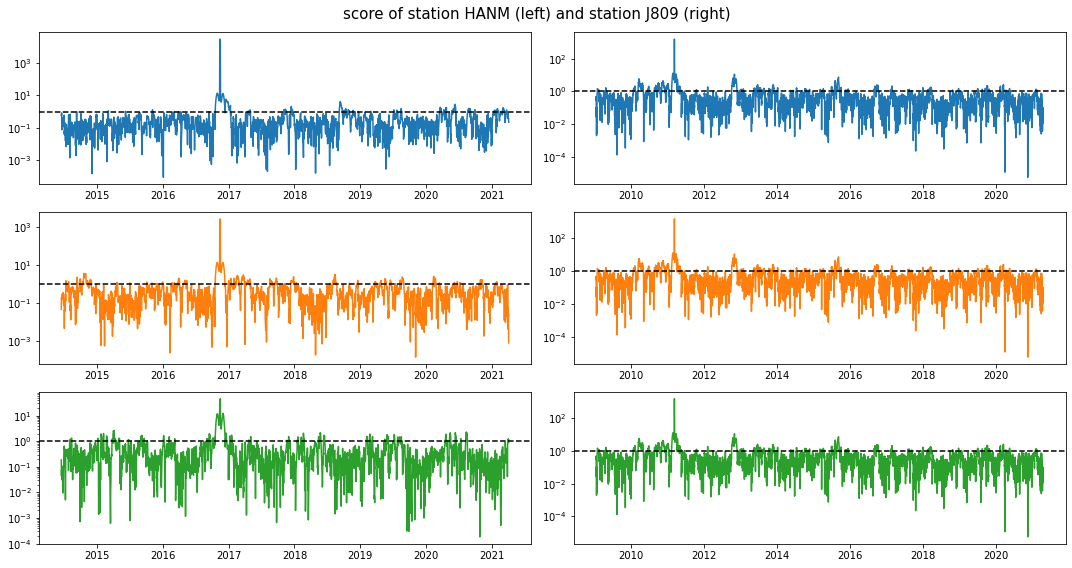

In [24]:
# plot score for both stations
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,8))
axes[0, 0].semilogy((results_east_1['score']).abs(), color='C0')
axes[0, 0].axhline(1, color='k', linestyle='--')
axes[1, 0].semilogy((results_north_1['score']).abs(), color='C1')
axes[1, 0].axhline(1, color='k', linestyle='--')
axes[2, 0].semilogy((results_up_1['score']).abs(), color='C2')
axes[2, 0].axhline(1, color='k', linestyle='--')

axes[0, 1].semilogy((results_east_2['score']).abs(), color='C0')
axes[0, 1].axhline(1, color='k', linestyle='--')
axes[1, 1].semilogy((results_east_2['score']).abs(), color='C1')
axes[1, 1].axhline(1, color='k', linestyle='--')
axes[2, 1].semilogy((results_east_2['score']).abs(), color='C2')
axes[2, 1].axhline(1, color='k', linestyle='--')

plt.suptitle('score of station HANM (left) and station J809 (right)', fontsize=15)
plt.tight_layout()

In [25]:
station1 = station1.reindex(idx1)
station2 = station2.reindex(idx2)

results_east_1 = results_east_1.reindex(idx1)
results_north_1 = results_north_1.reindex(idx1)
results_up_1 = results_up_1.reindex(idx1)

results_east_2 = results_east_2.reindex(idx2)
results_north_2 = results_north_2.reindex(idx2)
results_up_2 = results_up_2.reindex(idx2)

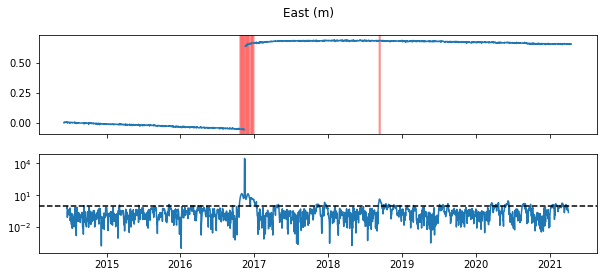

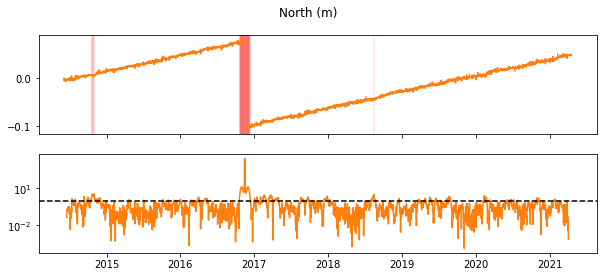

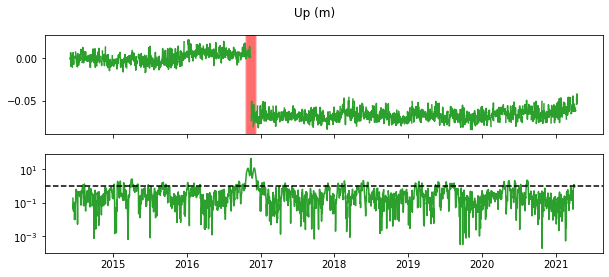

In [26]:
def plot_results(score, station_comp, threshold=2, color='C0', title=''):
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,4), sharex=True)
    axs[1].semilogy(score, color=color)
    axs[1].axhline(1, color='k', linestyle='--')
    axs[0].plot(station_comp, color=color, zorder=3)

    dates_score = station_comp[score>threshold]
    for i_date in dates_score.index:
        axs[0].axvline(i_date, color='r', linestyle='-', alpha=0.1, zorder=1)
    plt.suptitle(title)

# plot observations and score
plot_results((results_east_1['score']).abs(), station1['east(m)'], threshold=3, color='tab:blue', title='East (m)')
plot_results((results_north_1['score']).abs(), station1['north(m)'], threshold=3, color='tab:orange', title='North (m)')
plot_results((results_up_1['score']).abs(), station1['up(m)'], threshold=3, color='tab:green', title='Up (m)')

#plot_results((results_east_2['score']).abs(), station2['east(m)'], threshold=3, color='tab:blue', title='East (m)')
#plot_results((results_north_2['score']).abs(), station2['north(m)'], threshold=3, color='tab:orange', title='North (m)')
#plot_results((results_up_2['score']).abs(), station2['up(m)'], threshold=3, color='tab:green', title='Up (m)')

# Any questions?